In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Math, Latex

from sklearn.linear_model import LinearRegression
model = LinearRegression()

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
ids = pd.read_csv("../ds/inflation.csv").query("""
    INDICATOR == 'CPI' and MEASURE == 'AGRWTH' and SUBJECT == 'TOT'
""")

uds = pd.read_csv("../ds/unemployment.csv").query("""
    SUBJECT == 'TOT'
""")

ods = pd.read_csv("../ds/oil.csv")

In [2]:
countries = [
    "USA" #, "JPN", "GBR", "DEU"
]

sy = 2019 # 3 years
ly = 2010 # 10 years
ey = 2021 # excluding this year

endYear = str(ey)
endPrevYear = str(ey - 1)

In [3]:
class run:
    i = 5
    u = 5
    o = 5
    e = 5
    text = ""
    file = ""
    query = ""
    year = ""
    prevYear = ""
    freq = ''

s = run()
s.year = str(sy)
s.prevYear = str(sy - 1)
s.freq = 'M'
s.text = "Short Run"
s.file = "sr"


l = run()
l.year = str(ly)
l.prevYear = str(ly - 1)
l.freq = 'A'
l.text = "Long Run"
l.file = "lr"

runs = [l, s]

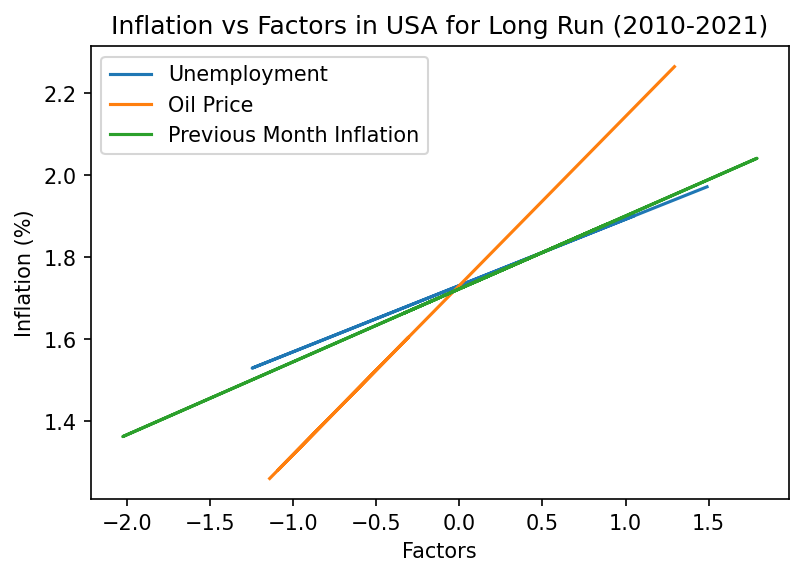

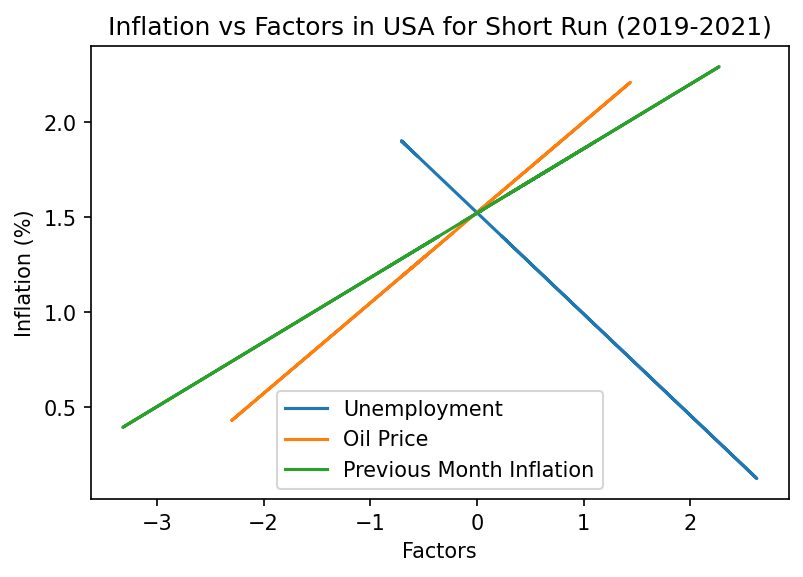

In [4]:
text = "Factors"#"($ u- \overline{u}$ )"

for country in countries:
    for run in runs:
        run.query = """
            TIME > @run.year and TIME < @endYear and FREQUENCY == @run.freq
        """
        run.i = ids.query(run.query)
        run.u = uds.query(run.query)
        run.o = ods.query(run.query)
        run.e = ids.query("""
            TIME > @run.prevYear and TIME < @endPrevYear and FREQUENCY == @run.freq
        """)

        # output - no Feature Scaling
        i = run.i.query("LOCATION == @country")["Value"].reset_index(drop=True)

        # input - Feature Scaling
        uval = run.u.query("LOCATION == @country")["Value"].reset_index(drop=True)
        u = ( uval - uval.mean() )/uval.std()

        oval = run.o.query("LOCATION == @country")["Value"].reset_index(drop=True)
        o = ( oval - oval.mean() )/oval.std()

        iprev = run.e.query("LOCATION == @country")["Value"].reset_index(drop=True)
        if iprev[0] is None: # data not available
            k = 0 # cuz Feature Scaling would've given 0 anyway
        else:
            k = ( iprev[0] - iprev.mean() )/ iprev.std()
        e = pd.Series( [k] )
        e = e.append(
            ( i - i.mean() )/iprev.std()
        , ignore_index=True).iloc[:-1]
        
        factors = ["Unemployment", "Oil Price", "Previous Month Inflation"]
        frame = { 
            factors[0]: u,
            factors[1]: o,
            factors[2]: e,

            "Current Inflation": i,
        }
        df = pd.DataFrame(frame)

        plt.figure(dpi=150).patch.set_facecolor('white')
        for factor in factors:
            model.fit(df[[ factor ]], df["Current Inflation"])

            prediction = model.predict( df[[ factor ]] )
            plt.plot(df[[ factor ]], prediction, label = factor)


        plt.title(
            "Inflation vs " + text + " in " + country + " for " + run.text + " (" + run.year + "-" + endYear + ")"
        )
        plt.xlabel(text), plt.ylabel("Inflation (%)"), plt.legend()

        plt.savefig("../img/" + run.file + ".svg", dpi=300, bbox_inches = 'tight')
        plt.show()

In [5]:
model.fit(df[factors], df["Current Inflation"])

print("The regression equation in", run.text, "for", country)

places = 3
display(Math(r"\pi_t = " +
    str( round( model.intercept_, places) ) +
    str( round(model.coef_[0], places) ) + "( u_t - \overline u )" +
    "+" + str( round(model.coef_[1], places) ) + "( O_t )" +
    "+" + str( round(model.coef_[2], places) ) + "( \pi_{t-1} )" 
))

print("(Rounded-off to", places, "places for viewing)")

The regression equation in Short Run for USA


<IPython.core.display.Math object>

(Rounded-off to 3 places for viewing)


In [6]:
prediction = model.predict( df[factors] )
df["Predicted Inflation"] = prediction

df["% Error"] = 100 * (df["Predicted Inflation"] - df["Current Inflation"]) / df["Current Inflation"]

print("Comparing model with the first few observations of training set in", run.text)
df.head()

Comparing model with the first few observations of training set in Short Run


,Unemployment,Oil Price,Previous Month Inflation,Current Inflation,Predicted Inflation,% Error
0,-0.558977,0.028078,-0.134019,1.551235,1.651445,6.460039
1,-0.617946,0.609731,0.063799,1.520135,1.779817,17.082847
2,-0.617946,0.966761,-0.009642,1.862523,1.820759,-2.242337
3,-0.647431,1.311182,0.798889,1.996440,1.996534,0.004711
4,-0.647431,1.439650,1.115127,1.790228,2.061404,15.147545


In [7]:
print("Using model for test set", run.text)

# test = pd.read_csv("../ds/test.csv")
test = pd.read_excel("../ds/test.xlsx")

test["Predicted Inflation"] = model.predict( test[factors] )
test

Using model for test set Short Run


,Unemployment,Oil Price,Previous Month Inflation,Predicted Inflation
0,8.114,33.192,7.480,5.327876
1,6.074,31.819,8.406,5.791187
2,5.028,34.018,6.871,6.154945
